# Dashboard Profile completion

In [81]:
import pymysql.cursors

import pandas as pd
import numpy as np
from time import time
import json
from sqlalchemy import create_engine
import re
import datetime
import lifetimes
#import pymc3 as pm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn-whitegrid')
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

import plotly
plotly.tools.set_config_file(world_readable=True , sharing='public')

In [61]:
connect_sql = pymysql.connect(host='prd-db-olxin-replica-1.cnhuszkczyjo.ap-southeast-1.rds.amazonaws.com',
                            user='dev',
                            password='^b6W2vVuM4KJ',
                            db='olxin',
                            charset='utf8mb4',
                            cursorclass=pymysql.cursors.DictCursor)

connect_sql_pk = pymysql.connect(host='prd-db-olxpk-replica-1.cnhuszkczyjo.ap-southeast-1.rds.amazonaws.com',
                            user='dev',
                            password='^b6W2vVuM4KJ',
                            db='olxpk',
                            charset='utf8mb4',
                            cursorclass=pymysql.cursors.DictCursor)

## India Cohort

-  First query : 05/07/2019

In [17]:
query = """

SELECT
        extract(year from created_at) as year  ,
        extract(month from created_at) as month,
        extract(week from created_at) as week,
        sum(case when ((google_id is null and facebook_id is null) or (google_id = '' and facebook_id = '')) then 0 else 1 end) social_account,
        sum(case when default_phone is null or default_phone='' then 0 else 1 end) as tiene_phone,
        sum(CASE
             WHEN email LIKE '%olx.co%' THEN 0 -- Autogenerado
             WHEN email LIKE '%@olx%' THEN 0 -- Autogenerado
             WHEN email LIKE '%DELETED%' THEN 0 -- Autogenerados
             WHEN email LIKE '%UNLINK%' THEN 0 -- Autogenerados
             WHEN email REGEXP '[0-9]{7}' THEN 0 -- Error de carga
             ELSE 1 END)  as valido_email,
        sum(case when default_person!='OLX User' then 1 else 0 end) as real_name,
        sum(case when b.external_key is not Null and b.external_key>0 then 1 else 0 end) has_photo,
        count(id)
        -- SUBSTRING_INDEX(email,'@',-1) as domain
FROM olxin.users a
    left join (select distinct external_key from olxin.images where active=1 and type='user') b on a.id=b.external_key
   where type in ('confirmed')
        and created_at > '2019-02-11'
group by 1,2,3

  
"""

In [18]:
df = pd.read_sql_query(query.replace('%', '%%'), connect_sql)

In [51]:
df_2019_05_07 = df.copy()

In [52]:
df_2019_05_07.year = df.year.astype(str)
df_2019_05_07.month = df.month.astype(str)
df_2019_05_07.week = df.week.astype(str)
df_2019_05_07['year_month_week'] = df_2019_05_07['year'] + '-' +  df_2019_05_07['month'] + '-' + df_2019_05_07['week'] 
df_2019_05_07.dtypes

year                          object
month                         object
week                          object
social_account               float64
tiene_phone                  float64
valido_email                 float64
real_name                    float64
has_photo                    float64
count(id)                      int64
year_month_week               object
percentage_social_account    float64
percentage_tiene_phone       float64
percentage_valid_email       float64
percentage_real_name         float64
percentage_has_photo         float64
dtype: object

In [53]:
df_2019_05_07['percentage_social_account'] = df_2019_05_07['social_account'] / df_2019_05_07['count(id)']
df_2019_05_07['percentage_tiene_phone'] = df_2019_05_07['tiene_phone'] / df_2019_05_07['count(id)']
df_2019_05_07['percentage_valid_email'] = df_2019_05_07['valido_email'] / df_2019_05_07['count(id)']
df_2019_05_07['percentage_real_name'] = df_2019_05_07['real_name'] / df_2019_05_07['count(id)']
df_2019_05_07['percentage_has_photo'] = df_2019_05_07['has_photo'] / df_2019_05_07['count(id)']

In [54]:
df_2019_05_07.head(20)

,year,month,week,social_account,tiene_phone,valido_email,real_name,has_photo,count(id),year_month_week,percentage_social_account,percentage_tiene_phone,percentage_valid_email,percentage_real_name,percentage_has_photo
0,2019,2,6,695989.0,390755.0,590153.0,774694.0,661497.0,1053099,2019-2-6,0.660896,0.371052,0.560397,0.735633,0.628143
1,2019,2,7,591106.0,401144.0,498624.0,671415.0,560882.0,963462,2019-2-7,0.613523,0.416357,0.517534,0.696878,0.582153
2,2019,2,8,387755.0,275663.0,325951.0,442587.0,369032.0,644644,2019-2-8,0.601503,0.427621,0.505629,0.686560,0.572459
3,2019,3,8,144412.0,111078.0,121102.0,166573.0,137277.0,248381,2019-3-8,0.581413,0.447208,0.487565,0.670635,0.552687
4,2019,3,9,531167.0,404078.0,447363.0,612309.0,505729.0,909585,2019-3-9,0.583966,0.444244,0.491832,0.673174,0.556000
5,2019,3,10,512313.0,401433.0,433994.0,591855.0,486449.0,891101,2019-3-10,0.574921,0.450491,0.487031,0.664184,0.545897
6,2019,3,11,508871.0,401085.0,428618.0,585650.0,487777.0,886662,2019-3-11,0.573918,0.452354,0.483406,0.660511,0.550127
7,2019,3,12,559362.0,427344.0,467741.0,642489.0,538112.0,958461,2019-3-12,0.583604,0.445865,0.488013,0.670334,0.561433
8,2019,3,13,85409.0,64893.0,71961.0,98077.0,82397.0,145827,2019-3-13,0.585687,0.445000,0.493468,0.672557,0.565033
9,2019,4,13,471331.0,365991.0,391867.0,538624.0,453692.0,803488,2019-4-13,0.586606,0.455503,0.487707,0.670357,0.564653


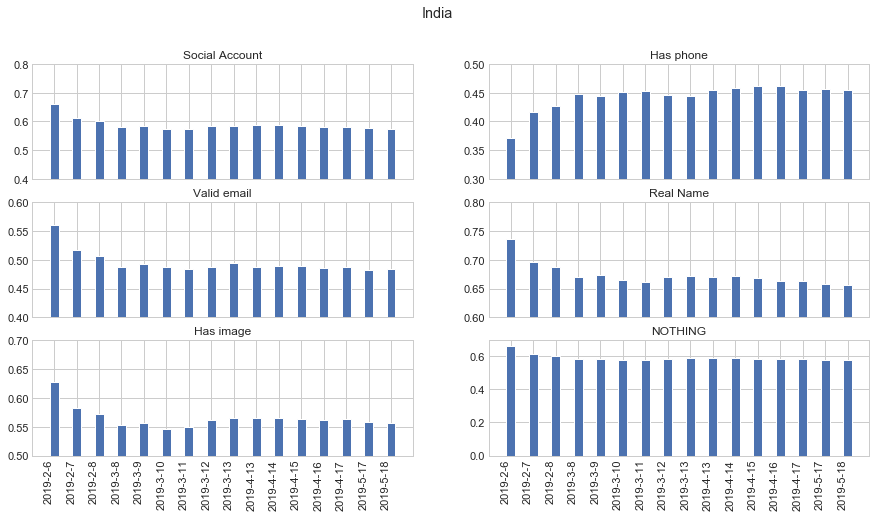

In [74]:
fig , ((ax1,ax2) , (ax3,ax4) , (ax5,ax6)) = plt.subplots(3,2,figsize=(15,8))

ax1.bar(df_2019_05_07.year_month_week, height=df_2019_05_07.percentage_social_account, width=.4)
ax1.set_title("Social Account")
ax1.set_ylim((0.4,0.8))

ax2.bar(df_2019_05_07.year_month_week, height=df_2019_05_07.percentage_tiene_phone, width=.4)
ax2.set_title("Has phone")
ax2.set_ylim((0.3,0.5))

ax3.bar(df_2019_05_07.year_month_week, height=df_2019_05_07.percentage_valid_email, width=.4)
ax3.set_title("Valid email")
ax3.set_ylim((0.4,0.6))

ax4.bar(df_2019_05_07.year_month_week, height=df_2019_05_07.percentage_real_name, width=.4)
ax4.set_title("Real Name")
ax4.set_ylim((0.6,0.8))

ax5.bar(df_2019_05_07.year_month_week, height=df_2019_05_07.percentage_has_photo, width=.4)
ax5.set_title("Has image")
ax5.set_ylim((0.5,0.7))

ax6.bar(df_2019_05_07.year_month_week, height=df_2019_05_07.percentage_social_account, width=.4)
ax6.set_title("NOTHING")

#fig.set_title('India')
fig.suptitle('India')

fig.autofmt_xdate(rotation = 90)

## Pakistan Cohort

-  First query : 05/07/2019

In [62]:
query = """

SELECT
        extract(year from created_at) as year ,
        extract(month from created_at) as month,
        extract(week from created_at) as week,
        sum(case when ((google_id is null and facebook_id is null) or (google_id = '' and facebook_id = '')) then 0 else 1 end) social_account,
        sum(case when default_phone is null or default_phone='' then 0 else 1 end) as tiene_phone,
        sum(CASE
             WHEN email LIKE '%olx.co%' THEN 0 -- Autogenerado
             WHEN email LIKE '%@olx%' THEN 0 -- Autogenerado
             WHEN email LIKE '%DELETED%' THEN 0 -- Autogenerados
             WHEN email LIKE '%UNLINK%' THEN 0 -- Autogenerados
             WHEN email REGEXP '[0-9]{7}' THEN 0 -- Error de carga
             ELSE 1 END)  as valido_email,
        sum(case when default_person!='OLX User' then 1 else 0 end) as real_name,
        sum(case when b.external_key is not Null and b.external_key>0 then 1 else 0 end) has_photo,
        count(id)
        -- SUBSTRING_INDEX(email,'@',-1) as domain
FROM olxpk.users a
    left join (select distinct external_key from olxpk.images where active=1 and type='user') b on a.id=b.external_key
   where type in ('confirmed')
        and created_at > '2019-02-11'
group by 1,2,3

  
"""

In [63]:
df2 = pd.read_sql_query(query.replace('%', '%%'), connect_sql_pk)

In [65]:
df2_2019_05_07 = df2.copy()

In [66]:
df2_2019_05_07.year = df.year.astype(str)
df2_2019_05_07.month = df.month.astype(str)
df2_2019_05_07.week = df.week.astype(str)
df2_2019_05_07['year_month_week'] = df2_2019_05_07['year'] + '-' +  df2_2019_05_07['month'] + '-' + df2_2019_05_07['week'] 
df2_2019_05_07.dtypes

year                object
month               object
week                object
social_account     float64
tiene_phone        float64
valido_email       float64
real_name          float64
has_photo          float64
count(id)            int64
year_month_week     object
dtype: object

In [67]:
df2_2019_05_07['percentage_social_account'] = df2_2019_05_07['social_account'] / df2_2019_05_07['count(id)']
df2_2019_05_07['percentage_tiene_phone'] = df2_2019_05_07['tiene_phone'] / df2_2019_05_07['count(id)']
df2_2019_05_07['percentage_valid_email'] = df2_2019_05_07['valido_email'] / df2_2019_05_07['count(id)']
df2_2019_05_07['percentage_real_name'] = df2_2019_05_07['real_name'] / df2_2019_05_07['count(id)']
df2_2019_05_07['percentage_has_photo'] = df2_2019_05_07['has_photo'] / df2_2019_05_07['count(id)']

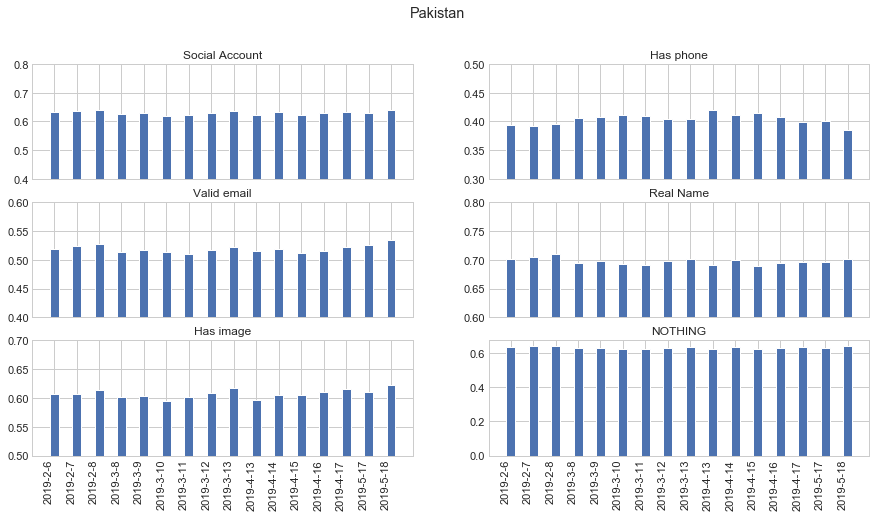

In [75]:
fig , ((ax1,ax2) , (ax3,ax4) , (ax5,ax6)) = plt.subplots(3,2,figsize=(15,8))

ax1.bar(df2_2019_05_07.year_month_week, height=df2_2019_05_07.percentage_social_account, width=.4)
ax1.set_title("Social Account")
ax1.set_ylim((0.4,0.8))

ax2.bar(df2_2019_05_07.year_month_week, height=df2_2019_05_07.percentage_tiene_phone, width=.4)
ax2.set_title("Has phone")
ax2.set_ylim((0.3,0.5))

ax3.bar(df2_2019_05_07.year_month_week, height=df2_2019_05_07.percentage_valid_email, width=.4)
ax3.set_title("Valid email")
ax3.set_ylim((0.4,0.6))

ax4.bar(df2_2019_05_07.year_month_week, height=df2_2019_05_07.percentage_real_name, width=.4)
ax4.set_title("Real Name")
ax4.set_ylim((0.6,0.8))

ax5.bar(df2_2019_05_07.year_month_week, height=df2_2019_05_07.percentage_has_photo, width=.4)
ax5.set_title("Has image")
ax5.set_ylim((0.5,0.7))

ax6.bar(df2_2019_05_07.year_month_week, height=df2_2019_05_07.percentage_social_account, width=.4)
ax6.set_title("NOTHING")

fig.suptitle('Pakistan')

fig.autofmt_xdate(rotation = 90)

## Trying to plotly

In [84]:
import plotly.dashboard_objs as dashboard

import IPython.display
from IPython.display import Image

my_dboard4 = dashboard.Dashboard()

In [119]:
trace1 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_tiene_phone'],
             name= 'Has phone'
)

trace2 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_valid_email'],
             name= 'Has email'
)



data = [trace1 , trace2]
#data2 = [trace0]


layout = dict(title = 'India',
              yaxis = dict(title='Percentage' , zeroline = False),
              xaxis = dict(title='Registration cohort' , zeroline = False , type='category'),
              width=500,
              height=500
             )

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='profile_completion_india')

url_1 = py.plot(fig, filename='profile_completion_india', auto_open=False ,sharing='public')
url_1

C:\Users\OLX - Lucas Dresi\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



'https://plot.ly/~MagicFredes/57'

In [118]:
trace0 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_social_account'],
             name= 'Social account'
            )

trace3 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_real_name'],
             name= 'Has real name'
)

trace4 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_has_photo'],
             name= 'Has photo'
)

data = [trace0 , trace3,trace4]
#data2 = [trace0]


layout = dict(title = 'India',
              yaxis = dict(title='Percentage' , zeroline = False),
              xaxis = dict(title='Registration cohort' , zeroline = False , type='category'),
              width=500,
              height=500
             )

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='profile_completion_india2')

url_2 = py.plot(fig, filename='profile_completion_india2', auto_open=False ,sharing='public')
url_2

C:\Users\OLX - Lucas Dresi\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



'https://plot.ly/~MagicFredes/61'

In [117]:
trace1 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_tiene_phone'],
             name= 'Has phone'
)

trace2 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_valid_email'],
             name= 'Has email'
)

data = [trace1 , trace2]

layout = dict(title = 'Pakistan',
              yaxis = dict(title='Percentage' , zeroline = False),
              xaxis = dict(title='Registration cohort' , zeroline = False , type='category'),
              width=500,
              height=500
             )

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='profile_completion_pakistan')

url_3 = py.plot(fig, filename='profile_completion_pakistan', auto_open=False ,sharing='public')
url_3

C:\Users\OLX - Lucas Dresi\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



'https://plot.ly/~MagicFredes/59'

In [116]:
trace0 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_social_account'],
             name= 'Social account'
            )


trace3 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_real_name'],
             name= 'Has real name'
)

trace4 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_has_photo'],
             name= 'Has photo'
)

data = [trace0 , trace3, trace4]

layout = dict(title = 'Pakistan',
              yaxis = dict(title='Percentage' , zeroline = False),
              xaxis = dict(title='Registration cohort' , zeroline = False , type='category'),
              width=500,
              height=500)
              
            

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='profile_completion_pakistan2')

url_4 = py.plot(fig, filename='profile_completion_pakistan2', auto_open=False ,sharing='public')
url_4

C:\Users\OLX - Lucas Dresi\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



'https://plot.ly/~MagicFredes/63'

In [99]:
import re

def fileId_from_url(url):
    """Return fileId from a url."""
    raw_fileId = re.findall("~[A-z]+/[0-9]+", url)[0][1: ]
    return raw_fileId.replace('/', ':')

fileId_1 = fileId_from_url(url_1)
fileId_2 = fileId_from_url(url_2)
fileId_3 = fileId_from_url(url_3)
fileId_4 = fileId_from_url(url_4)

In [101]:
box_a = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_1,
    'title': 'profile_completion_india'
}

box_b = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_2,
    'title': 'profile_completion_india2'
}

box_c = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_3,
    'title': 'profile_completion_pakistan'
}


box_d = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_4,
    'title': 'profile_completion_pakistan2'
}



In [102]:
my_dboard4.insert(box_a, 'below', 1)

In [103]:
my_dboard4.insert(box_b, 'right', 1)

In [106]:
my_dboard4.insert(box_c, 'below', 1)

In [107]:
my_dboard4.insert(box_d, 'below', 3)

In [120]:
import plotly.plotly as py
py.dashboard_ops.upload(my_dboard4, 'Profile completion')

'https://plot.ly/~MagicFredes/65/untitled-dashboard/'